### Author: Sophie Choe 

#### Portland State University, Electrical and Computer Engineering
February 2022

Dependencies: keras-nightly==2.5.0.dev2021032900 PennyLane==0.17.0 StrawberryFields==0.18.0 tensorflow-2.4.0-cp38-cp38-macosx_10_9_x86_64.whl

# 2-qumode classifier

Classical layers using keras dense and quantum layers using Pennylane

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers

import pennylane as qml
import numpy as np

import matplotlib.pyplot as plt

## 0. Loading data

In [2]:
mnist = keras.datasets.mnist

# datasets are numpy.ndarrays
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()     

# normalize the pixels from 0 ~ 225 to 0 ~ 1 
X_train, X_test = X_train / 255.0, X_test / 255.0

One hot encoding the labels. We want the labels to be of length cutoff_dim^(num_modes), hence pad with 6 zeros.

In [3]:
def one_hot(labels):  
       
    depth =  4**2                       # 10 classes + 6 zeros for padding
    indices = labels.astype(np.int32)    
    one_hot_labels = np.eye(depth)[indices].astype(np.float32) 
    
    return one_hot_labels

# one-hot encoded labels, each label of length cutoff dimension**2
y_train, y_test = one_hot(Y_train), one_hot(Y_test)

# using only 600 samples for training in this experiment
n_samples = 600
test_samples = 100
X_train, X_test, y_train, y_test = X_train[:n_samples], X_test[:test_samples], y_train[:n_samples], y_test[:test_samples]

## 1. Classical circuit

Define classical layers using Keras Sequential. Take in 28x28 image matrices, flatten, and output vectors of length 14. 3 hidden layers with ELU activation.

In [4]:
keras.backend.set_floatx('float32')

model = keras.models.Sequential([
                                 layers.Flatten(input_shape = (28,28)),
                                 layers.Dense(128, activation ="elu"),
                                 layers.Dense(64, activation ="elu"),
                                 layers.Dense(32, activation ="elu"),
                                 layers.Dense(14, activation ="elu") 
                                ])

# More than a million parameters for the classical circuit
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 14)                462       
Total params: 111,278
Trainable params: 111,278
Non-trainable params: 0
_________________________________________________________________


# 2. Data encoding circuit

Covert the output vectors from the classical circuit into quantum states by using the entries of the vectors as parameters of continous variable gates.

In [5]:
def data_encoding(x):
    qml.Squeezing(x[3], x[4], wires=0)
    qml.Squeezing(x[9], x[10], wires=1)
    
    qml.Beamsplitter(x[5], x[6], wires=[0,1])
    
    qml.Rotation(x[7], wires=0)
    qml.Rotation(x[8], wires=1)
    
    qml.Displacement(x[1], x[2], wires=0)
    qml.Displacement(x[11], x[12], wires=1)
    
    qml.Kerr(x[0], wires=0)
    qml.Kerr(x[13], wires=1)

# 3. Quantum neural network circuit

In [6]:
def qnn_layer(v):
    # Interferometer 1
    qml.Beamsplitter(v[0], v[1], wires=[0,1])
    qml.Rotation(v[2], wires=0)
    qml.Rotation(v[3], wires=1)
    
    # Squeezers
    qml.Squeezing(v[4], 0.0, wires=0)
    qml.Squeezing(v[5], 0.0, wires=1)
    
    # Interferometer 2
    qml.Beamsplitter(v[6], v[7], wires=[0,1])
    qml.Rotation(v[8], wires=0)
    qml.Rotation(v[9], wires=1)
    
    # Bias addition
    qml.Displacement(v[10], 0.0, wires=0)
    qml.Displacement(v[11], 0.0, wires=1)
    
    # Non-linear activation function
    qml.Kerr(v[12], wires=0)
    qml.Kerr(v[13], wires=1)

# 4. Initialize parameters

In [10]:
def init_weights(layers, modes, active_sd=0.0001, passive_sd=0.1):
    
    # Number of interferometer parameters: beamsplitter + 2 rotations
    M = 2 + 1 + 1  

    int1_weights = tf.random.normal(shape=[layers, M], stddev=passive_sd)
    s_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)
    int2_weights = tf.random.normal(shape=[layers, M], stddev=passive_sd)
    dr_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)
    k_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)

    weights = tf.concat([int1_weights, s_weights, int2_weights, dr_weights, k_weights], axis=1)
    weights = tf.Variable(weights)

    return weights

# 5. Quantum device

In [8]:
num_modes = 2
cutoff_dim = 4

# select a devide 
dev = qml.device("strawberryfields.fock", wires=num_modes, cutoff_dim=cutoff_dim) 

@qml.qnode(dev, interface="tf")
def quantum_nn(inputs, var):
    # Encode input x into quantum state
    data_encoding(inputs)

    # iterative quantum layers
    for v in var:
        qnn_layer(v)

    return qml.probs(wires=[0, 1])

# 6. Hybrid circuit

In [11]:
num_layers = 4

# initialize weights for quantum layers
weigths = init_weights(num_layers, num_modes)

# convert the quantum layer to a Keras layer
shape_tup = weigths.shape
weight_shapes = {'var': shape_tup}
qlayer = qml.qnn.KerasLayer(quantum_nn, weight_shapes, output_dim=4)

# add to the classical sequential model
model.add(qlayer)

# 7. Loss function and optimizer

In [12]:
opt = keras.optimizers.SGD(lr = 0.02)
model.compile(opt, loss = 'categorical_crossentropy', metrics =['accuracy'])

# 8. Training

In [7]:
hybrid = model.fit(X_train, 
                   y_train,
                   epochs = 150,
                   batch_size = 64,
                   shuffle = True, 
                   validation_data = (X_test, y_test))

Epoch 1/150
10/10 [==============================] - 351s 34s/step - loss: 2.8504 - accuracy: 0.1493 - val_loss: 2.3855 - val_accuracy: 0.1700
Epoch 2/150
10/10 [==============================] - 333s 33s/step - loss: 2.1749 - accuracy: 0.2604 - val_loss: 2.1902 - val_accuracy: 0.2700
Epoch 3/150
10/10 [==============================] - 325s 32s/step - loss: 2.0493 - accuracy: 0.3236 - val_loss: 2.1392 - val_accuracy: 0.3200
Epoch 4/150
10/10 [==============================] - 588s 62s/step - loss: 1.9556 - accuracy: 0.3739 - val_loss: 2.0701 - val_accuracy: 0.3400
Epoch 5/150
10/10 [==============================] - 396s 39s/step - loss: 1.8065 - accuracy: 0.3835 - val_loss: 1.9611 - val_accuracy: 0.3400
Epoch 6/150
10/10 [==============================] - 358s 36s/step - loss: 1.7062 - accuracy: 0.4234 - val_loss: 1.8944 - val_accuracy: 0.3900
Epoch 7/150
10/10 [==============================] - 3120s 33s/step - loss: 1.6922 - accuracy: 0.4237 - val_loss: 1.8995 - val_accuracy: 0.380

Epoch 58/150
10/10 [==============================] - 378s 38s/step - loss: 0.9203 - accuracy: 0.8494 - val_loss: 1.4017 - val_accuracy: 0.5700
Epoch 59/150
10/10 [==============================] - 336s 33s/step - loss: 0.9748 - accuracy: 0.8132 - val_loss: 1.4107 - val_accuracy: 0.5700
Epoch 60/150
10/10 [==============================] - 306s 30s/step - loss: 0.9625 - accuracy: 0.8267 - val_loss: 1.4181 - val_accuracy: 0.5300
Epoch 61/150
10/10 [==============================] - 7193s 796s/step - loss: 0.9241 - accuracy: 0.8756 - val_loss: 1.4105 - val_accuracy: 0.5300
Epoch 62/150
10/10 [==============================] - 3600s 366s/step - loss: 0.8755 - accuracy: 0.8762 - val_loss: 1.4482 - val_accuracy: 0.5100
Epoch 63/150
10/10 [==============================] - 9636s 1038s/step - loss: 0.9023 - accuracy: 0.8710 - val_loss: 1.3604 - val_accuracy: 0.5800
Epoch 64/150
10/10 [==============================] - 1647s 153s/step - loss: 0.9103 - accuracy: 0.8390 - val_loss: 1.4470 - val_

In [ ]:
model.summary()

# 9. Loss and accuracy graphs

In [ ]:
# ===================================================================================
#                                  Loss History Plot
# ===================================================================================

plt.title('model loss')
plt.plot(hybrid.history['loss'])
plt.ylabel('loss')
plt.show()

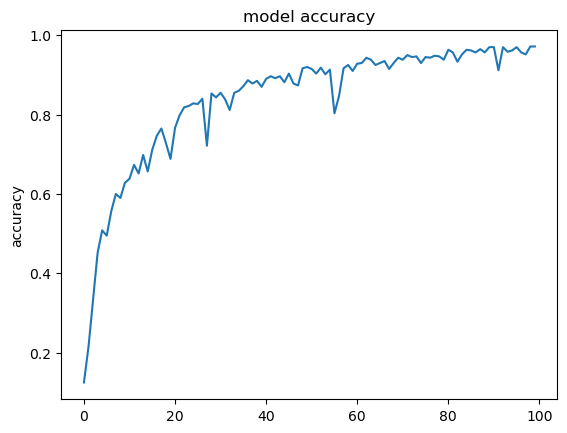

In [13]:
# ===================================================================================
#                                Accuracy History Plot
# ===================================================================================

plt.title('model accuracy')
plt.plot(hybrid.history['accuracy'])
plt.ylabel('accuracy')
plt.show()